In [27]:
import sys
import pandas as pd
import sklearn

print("Python:", sys.version)
print("pandas:", pd.__version__)
print("sklearn:", sklearn.__version__)


Python: 3.14.0 (tags/v3.14.0:ebf955d, Oct  7 2025, 10:15:03) [MSC v.1944 64 bit (AMD64)]
pandas: 2.3.3
sklearn: 1.7.2


In [28]:
import os, sys

# project root = parent of the notebooks/ folder
project_root = os.path.abspath("..")
print("Project root:", project_root)

# add project root to Python path so `src` becomes importable
sys.path.append(project_root)

from src.model import (
    load_processed_matches,
    prepare_features_from_processed,
    MatchOutcomeModel,
    train_match_outcome_model,
)

DATA_PATH = os.path.join(project_root, "Data", "processed", "matches_processed.csv")
DATA_PATH


Project root: c:\Users\uhtegi\Documents\Ülikool\3.semester\Sissejuhatus andmeteadusesse\EPL-Prediction-model


'c:\\Users\\uhtegi\\Documents\\Ülikool\\3.semester\\Sissejuhatus andmeteadusesse\\EPL-Prediction-model\\Data\\processed\\matches_processed.csv'

In [29]:
result_rf = train_match_outcome_model(
    data_path=DATA_PATH,
    model_type="rf",
    test_size=0.2,
    random_state=42,
)

result_rf.keys()


Loading processed matches from c:\Users\uhtegi\Documents\Ülikool\3.semester\Sissejuhatus andmeteadusesse\EPL-Prediction-model\Data\processed\matches_processed.csv...


dict_keys(['model', 'X_train', 'X_test', 'y_train', 'y_test', 'metrics', 'feature_importances', 'feature_names'])

In [30]:
metrics = result_rf["metrics"]

print("=== Random Forest performance ===")
print(f"Accuracy:  {metrics['accuracy']:.4f}")
print(f"Log loss:  {metrics['log_loss']:.4f}")
print("\nClassification report:")
print(metrics["classification_report"])


=== Random Forest performance ===
Accuracy:  0.5607
Log loss:  0.9900

Classification report:
              precision    recall  f1-score   support

        away     0.5309    0.5695    0.5495       151
        draw     0.4737    0.0857    0.1452       105
        home     0.5846    0.8071    0.6780       197

    accuracy                         0.5607       453
   macro avg     0.5297    0.4875    0.4576       453
weighted avg     0.5410    0.5607    0.5117       453



In [31]:
fi_rf = result_rf["feature_importances"]
fi_rf.head(20)


,feature,importance
7,away_roll_xg,0.090551
0,home_roll_xg,0.088542
3,home_roll_goals_scored,0.067391
5,home_venue_goals_scored,0.066544
1,home_roll_points,0.065745
8,away_roll_points,0.063143
10,away_roll_goals_scored,0.062346
9,away_roll_goals_conceded,0.060320
2,home_roll_goals_conceded,0.059790
4,home_venue_points,0.059257


In [32]:
model = result_rf["model"]
X_test = result_rf["X_test"]
y_test = result_rf["y_test"]

proba_df = model.predict_proba(X_test)
proba_df.head()



,prob_away,prob_draw,prob_home
257,0.292586,0.223149,0.484265
98,0.554067,0.204754,0.241179
1459,0.330767,0.315261,0.353972
62,0.114984,0.188769,0.696247
2050,0.493278,0.198772,0.307950


In [33]:
proba_df.describe()


,prob_away,prob_draw,prob_home
count,453.000000,453.000000,453.000000
mean,0.332754,0.233895,0.433351
std,0.168865,0.075864,0.177156
min,0.035246,0.025087,0.065857
25%,0.195817,0.188086,0.304017
50%,0.302460,0.229024,0.424619
75%,0.438484,0.275200,0.567363
max,0.852958,0.598917,0.902159


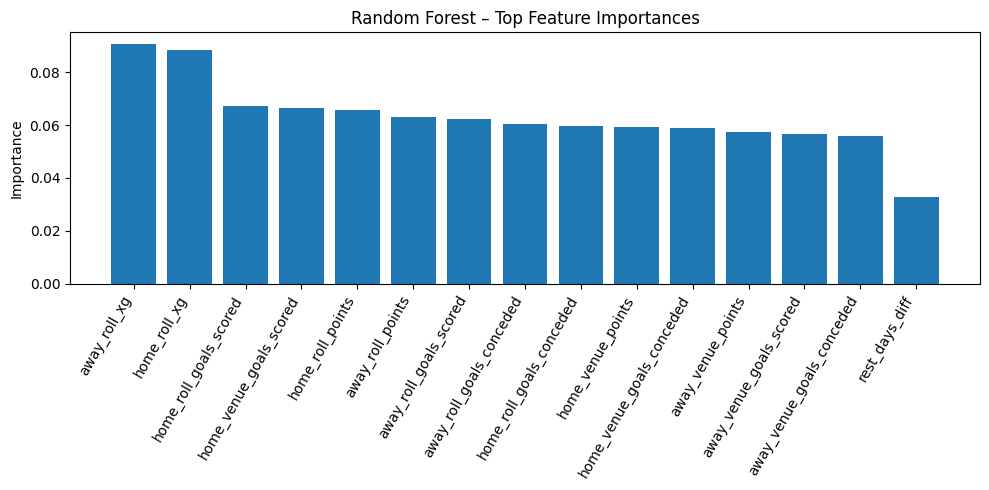

In [34]:
import matplotlib.pyplot as plt

top_n = 15
top_fi = fi_rf.head(top_n)

plt.figure(figsize=(10, 5))
plt.bar(top_fi["feature"], top_fi["importance"])
plt.xticks(rotation=60, ha="right")
plt.ylabel("Importance")
plt.title("Random Forest – Top Feature Importances")
plt.tight_layout()
plt.show()


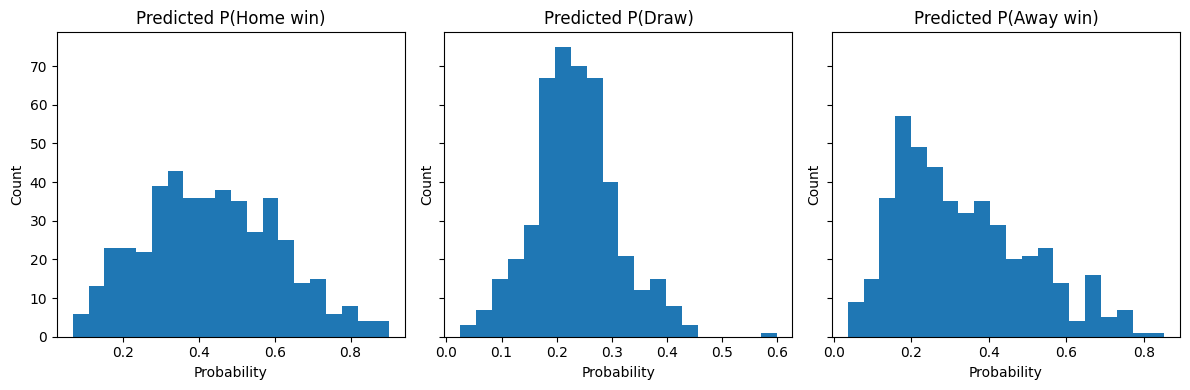

In [35]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

axes[0].hist(proba_df["prob_home"], bins=20)
axes[0].set_title("Predicted P(Home win)")

axes[1].hist(proba_df["prob_draw"], bins=20)
axes[1].set_title("Predicted P(Draw)")

axes[2].hist(proba_df["prob_away"], bins=20)
axes[2].set_title("Predicted P(Away win)")

for ax in axes:
    ax.set_xlabel("Probability")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()


In [36]:
sample_idx = proba_df.sample(10, random_state=42).index

example_preds = (
    proba_df.loc[sample_idx]
    .assign(true_outcome=y_test.loc[sample_idx].values)
)

example_preds


,prob_away,prob_draw,prob_home,true_outcome
790,0.071865,0.244313,0.683821,home
1663,0.557820,0.167122,0.275058,away
1976,0.528660,0.178567,0.292772,draw
779,0.653578,0.181936,0.164486,away
1929,0.173433,0.248362,0.578205,home
791,0.075520,0.025087,0.899393,draw
1183,0.154623,0.184835,0.660542,home
1444,0.202462,0.210131,0.587407,home
223,0.222770,0.223070,0.554160,home
1617,0.453915,0.314652,0.231433,home


## Model Evaluation & Performance

The Random Forest classifier was evaluated on a 20% hold-out test set using accuracy and log-loss as performance metrics. The model achieved an accuracy of approximately 0.56, indicating a clear improvement over random guessing and simple heuristic baselines such as predicting the majority class. The log-loss of ~0.99 suggests that the predicted probabilities are informative rather than arbitrarily confident.

Class-level analysis reveals notable asymmetry across outcomes. Home wins are predicted with relatively high recall (approximately 0.8), reflecting the strong home-field advantage present in the EPL. Away wins are identified with moderate accuracy, while draws remain the most challenging outcome, exhibiting substantially lower precision and recall. This difficulty is expected due to the lower frequency and inherent randomness of draws in football match outcomes.

## Feature Importance & Interpretability

Feature importance analysis indicates that the model relies primarily on recent underlying performance metrics. The most influential features are rolling expected goals for both teams (home_roll_xg, away_roll_xg), followed by venue-specific indicators such as goals scored, goals conceded, and points accumulated when playing at home or away.

These results confirm that chance quality and recent form are key drivers of match outcomes, while contextual variables such as rest-day differences and match timing (rest_days_diff, day_code, hour) contribute to a lesser degree. Overall, the model’s behavior aligns well with established football analytics insights and supports interpretability for non-technical users.

## Probability-Based Predictions

In addition to categorical predictions, the model outputs full probability distributions for home wins, draws, and away wins. The predicted probability histograms demonstrate clear asymmetry.

Inspection of individual probability outputs further illustrates the model’s behaviour. In most cases, predicted probabilities are moderately distributed across outcomes rather than concentrated on a single class, with the most likely outcome often receiving probabilities in the range of 0.55–0.70. This indicates that the model generally avoids excessive confidence, which is appropriate given the inherent uncertainty of football match results.

Draw probabilities are consistently lower and rarely emerge as the dominant prediction, typically remaining below 0.30 even in matches that ultimately end in a draw. This pattern helps explain the weaker predictive performance for draws, as the model seldom assigns them the highest likelihood. Occasional high-confidence mispredictions (e.g. a strong home-win probability assigned to a match that ends in a draw) highlight the remaining uncertainty and unpredictability of the task.

Overall, these probability-based outputs provide a richer basis for analysis than categorical predictions alone, enabling the identification of uncertain fixtures and supporting comparisons with external benchmarks such as bookmaker odds.

## Limitations & Future Work

The model does not incorporate player injuries, tactical adjustments, or transfer activity, which may have a significant impact on match outcomes. Additionally, draw prediction remains a limitation due to class imbalance and the inherent volatility of such results. Future work could involve hyperparameter tuning, evaluation of alternative models such as XGBoost, and the inclusion of richer contextual or player-level features to improve calibration and predictive performance.